In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

COINGECKO_API_URL = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range"
historical_data = []

# Define chunk size (CoinGecko allows max 90 days for hourly data)
DAYS_PER_REQUEST = 90

# Define start and end timestamps (Last 365 days from today)
end_date = datetime.now(tz=timezone.utc)
start_date = end_date - timedelta(days=365)

# Convert start and end dates to UNIX timestamps
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Fetch data in chunks of 90 days
current_start = start_timestamp
while current_start < end_timestamp:
    current_end = min(current_start + (DAYS_PER_REQUEST * 24 * 60 * 60), end_timestamp)

    params = {
        "vs_currency": "usd",
        "from": current_start,
        "to": current_end
    }

    print(f"Fetching data from {datetime.utcfromtimestamp(current_start).strftime('%Y-%m-%d')} "
          f"to {datetime.utcfromtimestamp(current_end).strftime('%Y-%m-%d')}...")

    response = requests.get(COINGECKO_API_URL, params=params)

    if response.status_code == 200:
        data = response.json().get("prices", [])  # Get only price data (OHLCV not provided in free API)

        for entry in data:
            timestamp = datetime.utcfromtimestamp(entry[0] / 1000).strftime('%Y-%m-%d %H:%M:%S')
            price = entry[1]
            historical_data.append([timestamp, price])
    else:
        print(f"Error fetching data: {response.status_code} - {response.text}")
        break

    current_start = current_end  # Move to next chunk

# Convert to Pandas DataFrame
df = pd.DataFrame(historical_data, columns=["Timestamp", "Price"])

# Save data as CSV
df.to_csv("eth_usdc_hr_year.csv", index=False)

print("Data saved successfully as 'eth_usdc_hourly_prices_1year.csv'")

Fetching data from 2024-02-14 to 2024-05-14...
Fetching data from 2024-05-14 to 2024-08-12...
Fetching data from 2024-08-12 to 2024-11-10...
Fetching data from 2024-11-10 to 2025-02-08...
Fetching data from 2025-02-08 to 2025-02-13...
Error fetching data: 429 - {"status":{"error_code":429,"error_message":"You've exceeded the Rate Limit. Please visit https://www.coingecko.com/en/api/pricing to subscribe to our API plans for higher rate limits."}}
Data saved successfully as 'eth_usdc_hourly_prices_1year.csv'


In [ ]:
df

,Timestamp,Price
0,2024-02-14 21:00:56,2763.901342
1,2024-02-14 22:00:34,2785.549151
2,2024-02-14 23:01:37,2774.891328
3,2024-02-15 00:01:56,2780.175964
4,2024-02-15 01:00:38,2821.103770
...,...,...
8630,2025-02-08 16:03:51,2603.036732
8631,2025-02-08 17:03:49,2611.309897
8632,2025-02-08 18:03:57,2629.507374
8633,2025-02-08 19:04:23,2632.167718


In [ ]:
df.isna().sum()

,0
Timestamp,0
Price,0


In [ ]:
df.rename(columns={'Timestamp':'timestamp','Price':'price'},inplace=True)

In [ ]:
eth_data = df.copy()

In [ ]:
eth_data

,timestamp,price
0,2024-02-14 21:00:56,2763.901342
1,2024-02-14 22:00:34,2785.549151
2,2024-02-14 23:01:37,2774.891328
3,2024-02-15 00:01:56,2780.175964
4,2024-02-15 01:00:38,2821.103770
...,...,...
8630,2025-02-08 16:03:51,2603.036732
8631,2025-02-08 17:03:49,2611.309897
8632,2025-02-08 18:03:57,2629.507374
8633,2025-02-08 19:04:23,2632.167718


In [ ]:
pip install pandas numpy matplotlib yfinance scipy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

#This is Working fine

In [ ]:
def initialize_data(eth_data):
    """
    Initializes the simulation with historical ETH price data.
    Args:
        eth_data (pd.DataFrame): DataFrame with 'timestamp' and 'price' columns.
    Returns:
        pd.DataFrame: DataFrame with added columns for simulation results.
    """
    # Use the last year of data from today
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=365)

    eth_data['timestamp'] = pd.to_datetime(eth_data['timestamp'])
    eth_data = eth_data.set_index('timestamp')
    eth_data = eth_data[eth_data.index >= start_date].copy()
    eth_data['lp_value'] = np.nan
    eth_data['hodl_value'] = np.nan
    eth_data['impermanent_loss'] = 0.0
    eth_data['daily_returns'] = np.nan  #add daily return
    return eth_data


# 2. LP Position Setup
def calculate_range(price, x):
    """
    Calculates the liquidity range for a given price and x value.
    Args:
        price (float): Current ETH price.
        x (float): Percentage deviation for the range.
    Returns:
        tuple: Lower and upper bounds of the liquidity range.
    """
    lower_bound = price / (1 + x)
    upper_bound = price * (1 + x)
    return lower_bound, upper_bound

def initialize_lp_position(initial_eth, price, x):
    """
    Initializes the LP position with equal amounts of ETH and USDC.
    Args:
        initial_eth (float): Initial amount of ETH.
        price (float): Current ETH price.
        x (float): Percentage deviation for the range.
    Returns:
        tuple: Amount of ETH, amount of USDC, lower bound, and upper bound.
    """
    eth_amount = initial_eth / 2
    usdc_amount = eth_amount * price
    lower_bound, upper_bound = calculate_range(price, x)
    return eth_amount, usdc_amount, lower_bound, upper_bound

# 3. Rebalancing Logic
def rebalance(eth_amount, usdc_amount, current_price):
   """
   Rebalances the portfolio to maintain equal amounts of ETH and USDC.
   Args:
       eth_amount (float): Current amount of ETH.
       usdc_amount (float): Current amount of USDC.
       current_price (float): Current ETH price.
   Returns:
       tuple: Updated amounts of ETH and USDC after rebalancing.
   """
   total_value = eth_amount * current_price + usdc_amount
   eth_target = total_value / (2 * current_price)
   usdc_target = total_value / 2

   eth_diff = eth_target - eth_amount
   usdc_diff = usdc_target - usdc_amount

   # Adjust amounts
   eth_amount = eth_target
   usdc_amount = usdc_target

   return eth_amount, usdc_amount

# 4. Impermanent Loss Calculation
def calculate_impermanent_loss(initial_eth, initial_usdc, current_eth, current_usdc, initial_price, current_price):
    """
    Calculates the impermanent loss (or gain) of the LP position.
    Args:
        initial_eth (float): Initial amount of ETH.
        initial_usdc (float): Initial amount of USDC.
        current_eth (float): Current amount of ETH.
        current_usdc (float): Current amount of USDC.
        initial_price (float): Initial ETH price.
        current_price (float): Current ETH price.
    Returns:
        float: Impermanent loss (or gain).
    """
    initial_value = initial_eth * initial_price + initial_usdc
    current_value = current_eth * current_price + current_usdc

    # Value if HODLing initial amounts of ETH and USDC
    hodl_value = initial_eth * current_price + initial_usdc

    # Impermanent Loss calculation
    impermanent_loss = current_value - hodl_value

    return impermanent_loss

# 5. HODL Strategy
def calculate_hodl_value(initial_eth, initial_price, current_price):
    """
    Calculates the value of a HODL strategy.
    Args:
        initial_eth (float): Initial amount of ETH.
        initial_price (float): Initial ETH price.
        current_price (float): Current ETH price.
    Returns:
        float: Value of the HODL strategy.
    """
    eth_half = initial_eth / 2
    usdc_half = (initial_eth / 2) * initial_price
    return (eth_half * current_price) + usdc_half

# 6. Backtesting Function
def backtest_lp_strategy(eth_data, initial_eth=100, x=0.10):
    """
    Backtests the LP strategy against a HODL strategy.
    Args:
        eth_data (pd.DataFrame): DataFrame with 'timestamp' and 'price' columns.
        initial_eth (float): Initial amount of ETH.
        x (float): Percentage deviation for the range.
    Returns:
        pd.DataFrame: DataFrame with simulation results.
    """
    eth_data = initialize_data(eth_data)
    initial_price = eth_data['price'].iloc[0]
    eth_amount, usdc_amount, lower_bound, upper_bound = initialize_lp_position(initial_eth, initial_price, x)
    hodl_value = calculate_hodl_value(initial_eth, initial_price, initial_price) # Initial HODL value

    # Store initial values
    initial_eth_amount = eth_amount
    initial_usdc_amount = usdc_amount

    impermanent_losses = [] # List to store impermanent losses

    for i in range(len(eth_data)):
        current_price = eth_data['price'].iloc[i]

        # Rebalance if price exits range
        if current_price < lower_bound or current_price > upper_bound:
            # Calculate impermanent loss
            impermanent_loss = calculate_impermanent_loss(initial_eth_amount, initial_usdc_amount, eth_amount, usdc_amount, initial_price, current_price)
            impermanent_losses.append(impermanent_loss) # Store impermanent loss
            eth_data['impermanent_loss'].iloc[i] = impermanent_loss

            # Rebalance portfolio
            eth_amount, usdc_amount = rebalance(eth_amount, usdc_amount, current_price)

            # Update range
            lower_bound, upper_bound = calculate_range(current_price, x)

        # Calculate LP value
        eth_data['lp_value'].iloc[i] = eth_amount * current_price + usdc_amount

        # Calculate HODL value
        hodl_value = calculate_hodl_value(initial_eth, initial_price, current_price)
        eth_data['hodl_value'].iloc[i] = hodl_value

    return eth_data, impermanent_losses

# 7. Performance Evaluation Metrics
def calculate_performance_metrics(df, initial_investment, initial_eth):
    """
    Calculates performance metrics for a given strategy.

    Args:
        df (pd.DataFrame): DataFrame with strategy values over time.
        initial_investment (float): Initial investment amount.
        initial_eth (float): Initial ETH amount for HODL calculation.

    Returns:
        dict: Dictionary containing calculated performance metrics.
    """
    # Calculate daily returns
    df['returns'] = df['lp_value'].pct_change()
    df['hodl_returns'] = df['hodl_value'].pct_change()

    # Time-Based Returns (Daily, Weekly, Monthly)
    daily_returns = df['returns'].resample('D').ffill().mean()  # Average daily returns
    weekly_returns = df['returns'].resample('W').ffill().mean()  # Average weekly returns
    monthly_returns = df['returns'].resample('M').ffill().mean()  # Average monthly returns

    # Calculate total returns
    total_returns = (df['lp_value'].iloc[-1] - initial_investment) / initial_investment
    hodl_final_value = df['hodl_value'].iloc[-1]
    hodl_returns = (hodl_final_value - initial_investment) / initial_investment

    # Calculate Sharpe Ratio
    sharpe_ratio = df['returns'].mean() / df['returns'].std() * np.sqrt(252)  # Assuming 252 trading days in a year
    hodl_sharpe_ratio = df['hodl_returns'].mean() / df['hodl_returns'].std() * np.sqrt(252)

    # Calculate Maximum Drawdown
    cumulative_returns = (1 + df['returns']).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    cumulative_hodl_returns = (1 + df['hodl_returns']).cumprod()
    hodl_peak = cumulative_hodl_returns.expanding(min_periods=1).max()
    hodl_drawdown = (cumulative_hodl_returns - hodl_peak) / hodl_peak
    hodl_max_drawdown = hodl_drawdown.min()

    metrics = {
        'Total Returns': total_returns,
        'Final Portfolio Value': df['lp_value'].iloc[-1],
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'HODL Final Value': hodl_final_value,
        'HODL Total Returns': hodl_returns,
        'HODL Sharpe Ratio': hodl_sharpe_ratio,
        'HODL Maximum Drawdown': hodl_max_drawdown,
        'Daily Return': daily_returns,
        'Weekly Return': weekly_returns,
        'Monthly Return': monthly_returns,
    }

    return metrics



# 8. Multi-X Backtesting and Comparison
def compare_strategies(eth_data, initial_eth=100, x_values=[0.05, 0.10, 0.15, 0.20, 0.25]):
    """
    Backtests the LP strategy for multiple x values and compares performance.

    Args:
        eth_data (pd.DataFrame): DataFrame with 'timestamp' and 'price' columns.
        initial_eth (float): Initial amount of ETH.
        x_values (list): List of x values to test.

    Returns:
        pd.DataFrame: DataFrame with performance metrics for each x value.
    """
    results = {}
    results_dfs = {}  # Store results_df for plotting
    hodl_metrics = {} # Store hodl metrics


    for x in x_values:
        # Run backtest for current x
        results_df, impermanent_losses = backtest_lp_strategy(eth_data.copy(), initial_eth, x)

        # Calculate Performance Metrics
        initial_investment = initial_eth * eth_data['price'].iloc[0]  # Initial investment in USD
        metrics = calculate_performance_metrics(results_df, initial_investment,initial_eth)

        # Store Results
        results[x] = metrics
        results_dfs[x] = results_df  # Store the complete results_df
        hodl_metrics = {k: metrics[k] for k in metrics if k.startswith('HODL')}

    # Convert Results to DataFrame
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    summary_df.index.name = 'X Value'

    hodl_df = pd.DataFrame.from_dict(hodl_metrics, orient='index').T #Convert HODL metrics to DataFrame
    return summary_df, results_dfs, hodl_df  # Return three DataFrames


def plot_price_and_range(eth_data, results_dfs, x_values):
    """
    Overlays the historical price data with active LP ranges and marks rebalancing points.

    Args:
        eth_data (pd.DataFrame): DataFrame with historical ETH price data.
        results_dfs (dict): Dictionary of DataFrames with simulation results for each x value.
        x_values (list): List of x values.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(eth_data.index, eth_data['price'], label='ETH Price', color='blue')

    for x in x_values:
        results_df = results_dfs[x]
        # Calculate upper and lower bounds
        results_df['upper_bound'] = results_df['price'] * (1 + x)
        results_df['lower_bound'] = results_df['price'] / (1 + x)

        # Plot the ranges
        plt.plot(results_df.index, results_df['upper_bound'], label=f'Upper Bound (x={x})', linestyle='--', alpha=0.5)
        plt.plot(results_df.index, results_df['lower_bound'], label=f'Lower Bound (x={x})', linestyle='--', alpha=0.5)

        # Mark rebalancing points (where impermanent loss is non-zero)
        rebalancing_points = results_df[results_df['impermanent_loss'] != 0].index
        plt.scatter(rebalancing_points, eth_data.loc[rebalancing_points, 'price'], color='red', marker='o', label=f'Rebalance (x={x})')

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title('ETH Price with LP Ranges and Rebalancing Points')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_risk_metrics(results_df, label=True):
    """
    Plots risk metrics (Sharpe Ratio, Maximum Drawdown) for different x values.

    Args:
        results_df (pd.DataFrame): DataFrame with performance metrics for each x value.
        label (bool): Whether to display the x value labels on the bars.
    """
    # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    x_values = results_df.index.astype(str)  # Get x values as strings for labels


    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Sharpe Ratio
    sns.barplot(x=x_values, y=results_df['Sharpe Ratio'], ax=axes[0], color='skyblue')
    axes[0].set_title('Sharpe Ratio for Different X Values')
    axes[0].set_xlabel('X Value')
    axes[0].set_ylabel('Sharpe Ratio')

    # Add value labels
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt="%.2f", fontsize=8, padding=3)

    # Maximum Drawdown
    sns.barplot(x=x_values, y=results_df['Maximum Drawdown'], ax=axes[1], color='salmon')
    axes[1].set_title('Maximum Drawdown for Different X Values')
    axes[1].set_xlabel('X Value')
    axes[1].set_ylabel('Maximum Drawdown')

    # Add value labels
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt="%.2f", fontsize=8, padding=3)

    plt.tight_layout()
    plt.show()



In [ ]:

# -------------------- Main Execution --------------------
# Define x values
x_values = [0.05, 0.10, 0.15, 0.20, 0.25]

# Run comparison
summary_df, results_dfs, hodl_df = compare_strategies(eth_data.copy(), x_values=x_values)

# Print comparison DataFrame
print("Summary DataFrame (LP Strategies):")
print(summary_df)

# Print HODL DataFrame
print("\nHODL DataFrame:")
print(hodl_df)


Summary DataFrame (LP Strategies):
         Total Returns  Final Portfolio Value  Sharpe Ratio  Maximum Drawdown  \
X Value                                                                         
0.05          0.036991          286614.027323      0.047215         -0.249016   
0.10          0.033880          285754.301707      0.045670         -0.255178   
0.15          0.037708          286812.160217      0.047559         -0.252161   
0.20          0.045502          288966.426949      0.051335         -0.248171   
0.25          0.020778          282133.100069      0.039119         -0.258814   

         HODL Final Value  HODL Total Returns  HODL Sharpe Ratio  \
X Value                                                            
0.05        270081.923493           -0.022824           0.019222   
0.10        270081.923493           -0.022824           0.019222   
0.15        270081.923493           -0.022824           0.019222   
0.20        270081.923493           -0.022824           0

In [ ]:
summary_df

,Total Returns,Final Portfolio Value,Sharpe Ratio,Maximum Drawdown,HODL Final Value,HODL Total Returns,HODL Sharpe Ratio,HODL Maximum Drawdown,Daily Return,Weekly Return,Monthly Return
X Value,,,,,,,,,,,
0.05,0.036991,286614.027323,0.047215,-0.249016,270081.923493,-0.022824,0.019222,-0.274742,0.000455,0.000598,0.001077
0.10,0.033880,285754.301707,0.045670,-0.255178,270081.923493,-0.022824,0.019222,-0.274742,0.000461,0.000600,0.001104
0.15,0.037708,286812.160217,0.047559,-0.252161,270081.923493,-0.022824,0.019222,-0.274742,0.000457,0.000580,0.001105
0.20,0.045502,288966.426949,0.051335,-0.248171,270081.923493,-0.022824,0.019222,-0.274742,0.000459,0.000593,0.001086
0.25,0.020778,282133.100069,0.039119,-0.258814,270081.923493,-0.022824,0.019222,-0.274742,0.000462,0.000598,0.001059


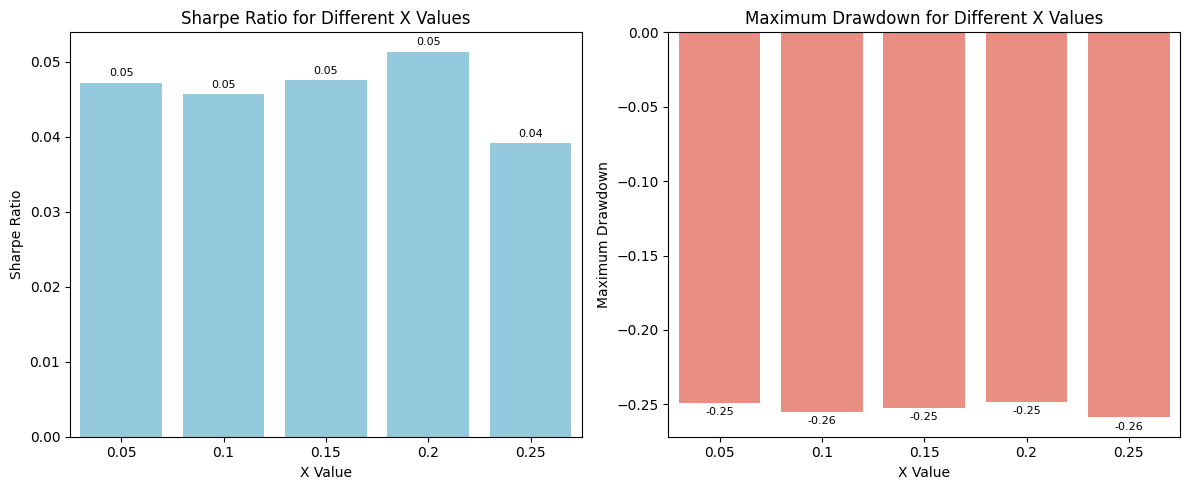

In [ ]:
# # Plot risk metrics
plot_risk_metrics(summary_df)

#New Era Started

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume the functions from the attached file are defined here
# (initialize_data, calculate_range, initialize_lp_position, rebalance,
# calculate_impermanent_loss, calculate_hodl_value, backtest_lp_strategy,
# calculate_performance_metrics, compare_strategies, plot_price_and_range,
# plot_risk_metrics)

def is_dominated(candidate, others, factors):
    """
    Checks if a candidate solution is dominated by any other solution.

    Args:
        candidate (pd.Series): Performance metrics of the candidate solution.
        others (pd.DataFrame): Performance metrics of other solutions.
        factors (dict): Dictionary specifying whether to maximize or minimize each factor.
                        e.g., {'Total Returns': 'maximize', 'Sharpe Ratio': 'maximize', 'Maximum Drawdown': 'minimize'}

    Returns:
        bool: True if the candidate is dominated, False otherwise.
    """
    for other_index, other in others.iterrows():
        dominates = True
        for factor, direction in factors.items():
            if direction == 'maximize':
                if other[factor] < candidate[factor]:
                    dominates = False
                    break
            elif direction == 'minimize':
                if other[factor] > candidate[factor]:
                    dominates = False
                    break
        if dominates:
            return True  # Candidate is dominated
    return False  # Candidate is not dominated


def pareto_frontier(data, factors):
    """
    Identifies the Pareto frontier (non-dominated solutions) from a set of solutions.

    Args:
        data (pd.DataFrame): DataFrame containing performance metrics for each solution.
        factors (dict): Dictionary specifying whether to maximize or minimize each factor.

    Returns:
        pd.DataFrame: DataFrame containing the Pareto frontier solutions.
    """
    pareto = []
    for index, row in data.iterrows():
        if not is_dominated(row, data.drop(index), factors):
            pareto.append(row)

    return pd.DataFrame(pareto)



In [ ]:
# 1. Define x_values
x_values = np.arange(0.01, 0.20, 0.01)

# 2. Run comparison for all x_values
all_summary_df, all_results_dfs, all_hodl_df = compare_strategies(eth_data.copy(), x_values=x_values)

In [ ]:
all_summary_df

,Total Returns,Final Portfolio Value,Sharpe Ratio,Maximum Drawdown,HODL Final Value,HODL Total Returns,HODL Sharpe Ratio,HODL Maximum Drawdown,Daily Return,Weekly Return,Monthly Return
X Value,,,,,,,,,,,
0.01,0.034249,285856.099856,0.045883,-0.249511,270081.923493,-0.022824,0.019222,-0.274742,0.000455,0.000598,0.001093
0.02,0.034749,285994.393035,0.046126,-0.248820,270081.923493,-0.022824,0.019222,-0.274742,0.000456,0.000599,0.001093
0.03,0.036219,286400.735008,0.046848,-0.248472,270081.923493,-0.022824,0.019222,-0.274742,0.000457,0.000599,0.001095
0.04,0.040197,287500.079818,0.048783,-0.249385,270081.923493,-0.022824,0.019222,-0.274742,0.000457,0.000600,0.001099
0.05,0.036991,286614.027323,0.047215,-0.249016,270081.923493,-0.022824,0.019222,-0.274742,0.000455,0.000598,0.001077
0.06,0.037539,286765.598363,0.047499,-0.249250,270081.923493,-0.022824,0.019222,-0.274742,0.000460,0.000597,0.001087
0.07,0.038566,287049.463321,0.047985,-0.247239,270081.923493,-0.022824,0.019222,-0.274742,0.000459,0.000598,0.001086
0.08,0.035196,286117.979697,0.046339,-0.249099,270081.923493,-0.022824,0.019222,-0.274742,0.000459,0.000607,0.001087
0.09,0.036194,286393.765429,0.046835,-0.247528,270081.923493,-0.022824,0.019222,-0.274742,0.000459,0.000607,0.001084


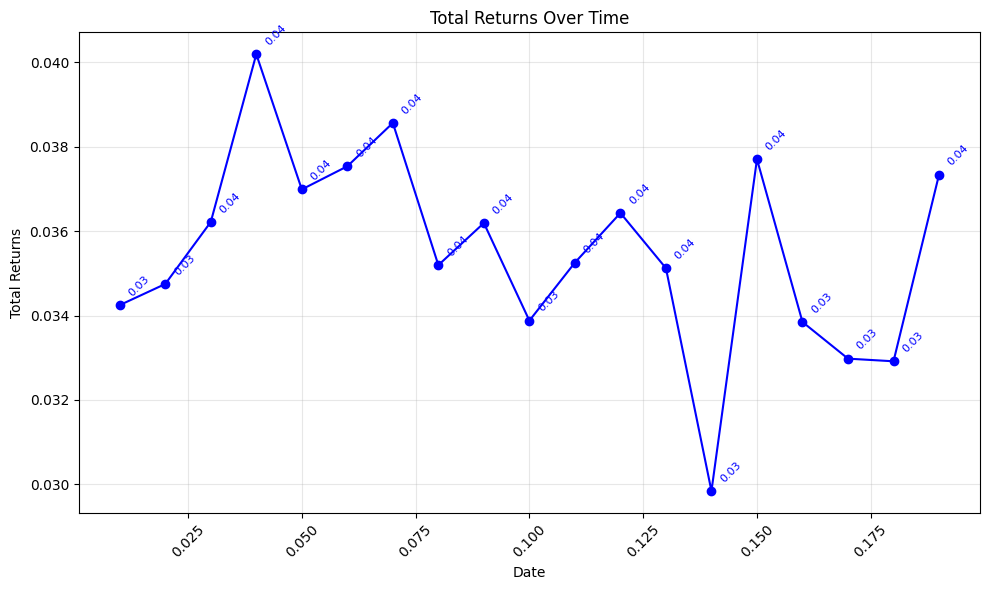

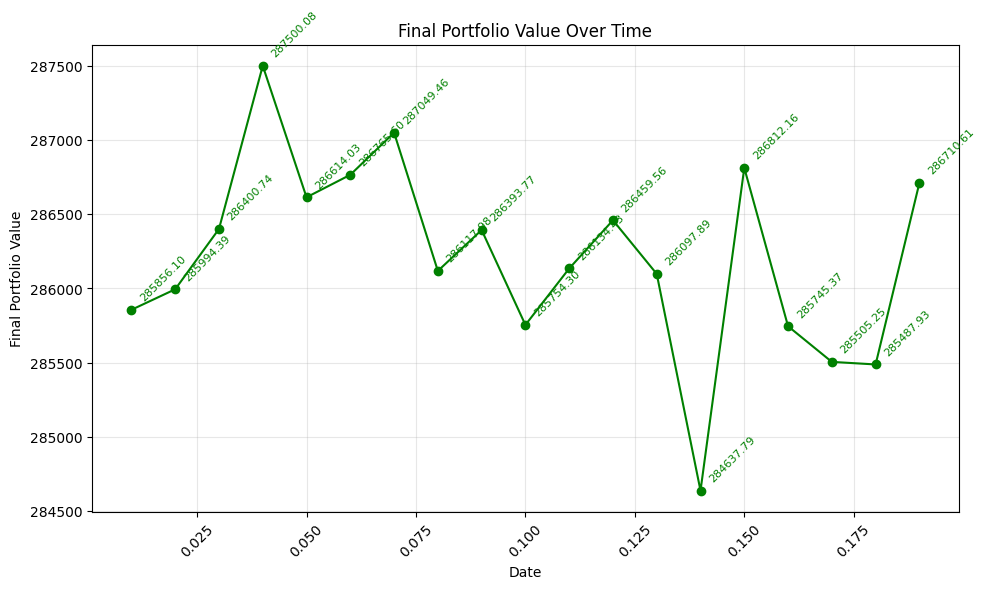

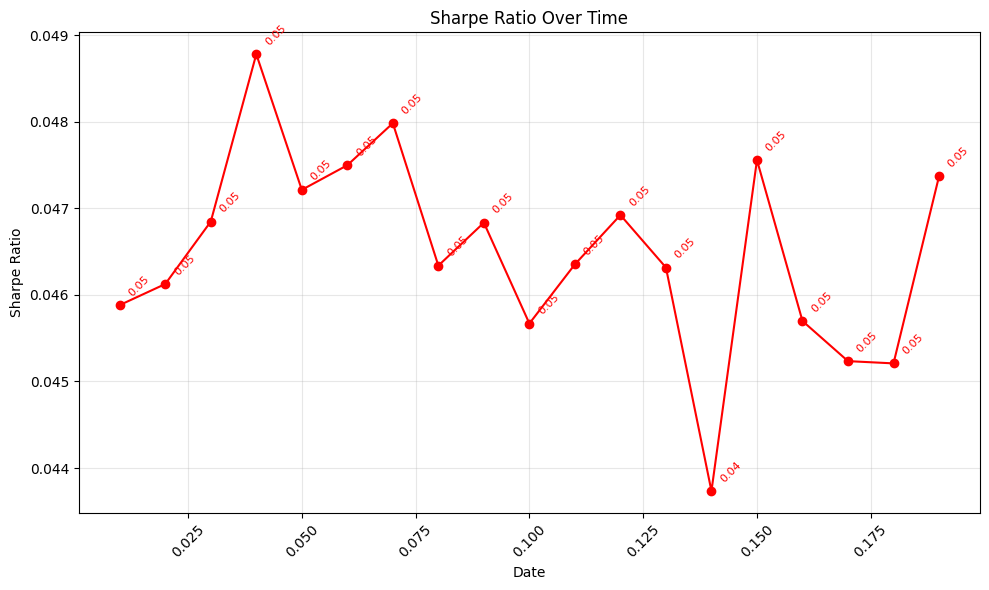

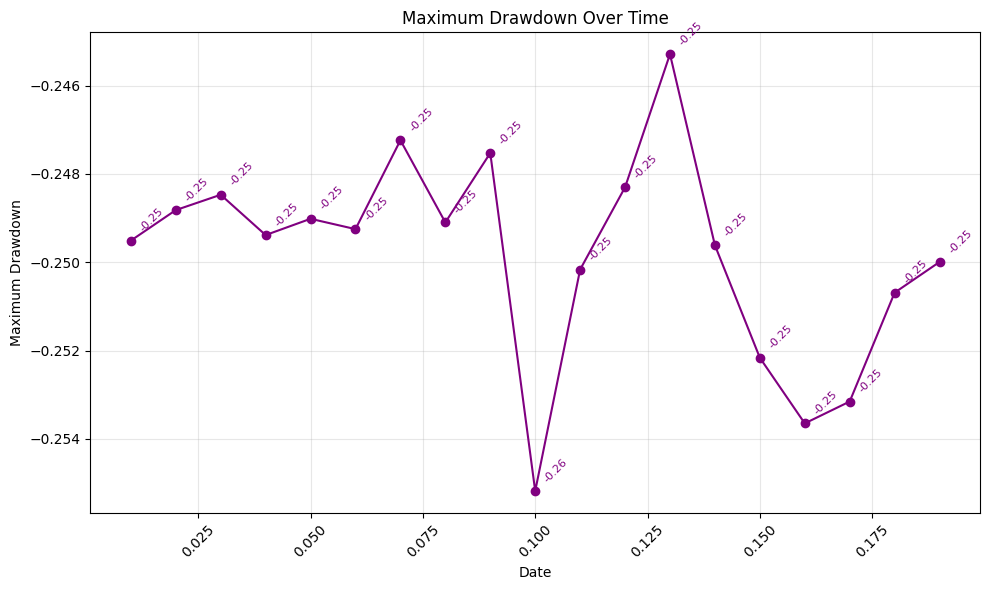

In [ ]:
import matplotlib.pyplot as plt

metrics = ['Total Returns', 'Final Portfolio Value', 'Sharpe Ratio', 'Maximum Drawdown']
colors = ['blue', 'green', 'red', 'purple']

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(10, 6))
    plt.plot(all_summary_df.index, all_summary_df[metric], color=color,marker='o')

    for x, y in zip(all_summary_df.index, all_summary_df[metric]):
      plt.annotate(f'{y:.2f}',
                  xy=(x, y),
                  xytext=(5, 5),
                  textcoords='offset points',
                  ha='left',
                  va='bottom',
                  color=color,
                  fontsize=8,
                  rotation=45)
      plt.xticks(rotation=45)
    plt.title(f'{metric} Over Time')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# 3. Define factors for Pareto Frontier
factors = {
    'Total Returns': 'maximize',
    'Sharpe Ratio': 'maximize',
    'Maximum Drawdown': 'minimize'
}

# 4. Apply Pareto Frontier
pareto_df = pareto_frontier(all_summary_df, factors)

# 5. Get top 5 performer based on the pareto frontier
if len(pareto_df) > 5:
     #For simplicity, let's assume that we average the factors' ranking and take top 5 from there
     #We inverse max drawdown to have all metrics maximizing
    pareto_df['Max Drawdown Inverse'] = -pareto_df['Maximum Drawdown']
    pareto_df['Average Rank'] = pareto_df[['Total Returns', 'Sharpe Ratio', 'Max Drawdown Inverse']].mean(axis=1)
    top_5_pareto = pareto_df.nlargest(5, 'Average Rank')
else:
    top_5_pareto = pareto_df

# 6. Extract the top 5 x values from the Pareto Frontier
top_5_x_values = [round(x, 2) for x in top_5_pareto.index.tolist()]

In [ ]:
print(top_5_x_values)

[0.04, 0.1, 0.15, 0.16]


In [ ]:
top_5_pareto

,Total Returns,Final Portfolio Value,Sharpe Ratio,Maximum Drawdown,HODL Final Value,HODL Total Returns,HODL Sharpe Ratio,HODL Maximum Drawdown,Daily Return,Weekly Return,Monthly Return
0.04,0.040197,287500.079818,0.048783,-0.249385,270081.923493,-0.022824,0.019222,-0.274742,0.000457,0.000600,0.001099
0.10,0.033880,285754.301707,0.045670,-0.255178,270081.923493,-0.022824,0.019222,-0.274742,0.000461,0.000600,0.001104
0.15,0.037708,286812.160217,0.047559,-0.252161,270081.923493,-0.022824,0.019222,-0.274742,0.000457,0.000580,0.001105
0.16,0.033848,285745.372537,0.045699,-0.253647,270081.923493,-0.022824,0.019222,-0.274742,0.000465,0.000607,0.001118


In [ ]:
# 7. Re-run comparison with top 5 x values (optional, if you need detailed results for just the top performers)
summary_df, results_dfs, hodl_df = compare_strategies(eth_data.copy(), x_values=top_5_x_values)

# 8. Print Results
print("Pareto Frontier (Top 5 X Values):")
print(top_5_x_values)

print("\nSummary DataFrame (LP Strategies - Top 5 Pareto):")
print(summary_df)

print("\nHODL DataFrame:")
print(hodl_df)


Pareto Frontier (Top 5 X Values):
[0.04, 0.1, 0.15, 0.16]

Summary DataFrame (LP Strategies - Top 5 Pareto):
         Total Returns  Final Portfolio Value  Sharpe Ratio  Maximum Drawdown  \
X Value                                                                         
0.04          0.040197          287500.079818      0.048783         -0.249385   
0.10          0.033880          285754.301707      0.045670         -0.255178   
0.15          0.037708          286812.160217      0.047559         -0.252161   
0.16          0.033848          285745.372537      0.045699         -0.253647   

         HODL Final Value  HODL Total Returns  HODL Sharpe Ratio  \
X Value                                                            
0.04        270081.923493           -0.022824           0.019222   
0.10        270081.923493           -0.022824           0.019222   
0.15        270081.923493           -0.022824           0.019222   
0.16        270081.923493           -0.022824           0.019222

##Optimal X_value = 0.04 (Max final_portfolio_value)

In [ ]:
def analyze_lp_performance(eth_data, x_value, initial_eth=100):
    """
    Analyzes the performance of an LP strategy for a given x value and compares it to HODL.

    Args:
        eth_data (pd.DataFrame): DataFrame with 'timestamp' and 'price' columns.
        x_value (float): The x value to use for the LP strategy.
        initial_eth (float): Initial amount of ETH.

    Returns:
        dict: Dictionary containing the performance analysis results.
    """

    # Backtest the LP strategy
    results_df, impermanent_losses = backtest_lp_strategy(eth_data.copy(), initial_eth=initial_eth, x=x_value)

    # Calculate initial investment
    initial_investment = initial_eth * eth_data['price'].iloc[0]

    # Calculate performance metrics
    metrics = calculate_performance_metrics(results_df, initial_investment, initial_eth)

    # Extract relevant metrics
    total_returns = metrics['Total Returns']
    sharpe_ratio = metrics['Sharpe Ratio']
    max_drawdown = metrics['Maximum Drawdown']
    hodl_total_returns = metrics['HODL Total Returns']
    hodl_final_value = metrics['HODL Final Value']
    final_portfolio_value = metrics['Final Portfolio Value']

    # Calculate impermanent loss at each rebalance point
    rebalancing_impermanent_losses = results_df[results_df['impermanent_loss'] != 0]['impermanent_loss'].tolist()
    average_impermanent_loss = np.mean(rebalancing_impermanent_losses) if rebalancing_impermanent_losses else 0

    # Prepare results dictionary
    analysis_results = {
        "X Value": x_value,
        "Total Returns (LP)": total_returns,
        "Total Returns (HODL)": hodl_total_returns,
        "Final Portfolio Value (LP)": final_portfolio_value,
        "Final Portfolio Value (HODL)": hodl_final_value,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown,
        "Average Impermanent Loss": average_impermanent_loss,
        "Daily Return": metrics['Daily Return'],
        "Weekly Return": metrics['Weekly Return'],
        "Monthly Return": metrics['Monthly Return'],
        "Position Value Over Time": results_df['lp_value']  # LP value over time
    }

    return analysis_results


In [ ]:
# -------------------- Main Execution --------------------
# Optimal x_value
optimal_x_value = 0.04

# Perform the analysis
analysis_results = analyze_lp_performance(eth_data.copy(), optimal_x_value)

# Print the results
print("LP Performance Analysis:")
for key, value in analysis_results.items():
    print(f"{key}: {value}")

# Example usage of "Position Value Over Time"
position_value_over_time = analysis_results["Position Value Over Time"]
print("\nPosition Value Over Time (First 5 values):")
print(position_value_over_time.head())


LP Performance Analysis:
X Value: 0.04
Total Returns (LP): 0.0441439760505635
Total Returns (HODL): -0.01890740519346469
Final Portfolio Value (LP): 288591.09367666754
Final Portfolio Value (HODL): 271164.3139524148
Sharpe Ratio: 0.046749533221067084
Maximum Drawdown: -0.2493847094203477
Average Impermanent Loss: 8125.3822841909405
Daily Return: 0.00045742831826368533
Weekly Return: 0.0006002585361531421
Monthly Return: 0.0010985310809119148
Position Value Over Time: timestamp
2024-02-14 22:00:34    278554.915130
2024-02-14 23:01:37    278022.023980
2024-02-15 00:01:56    278286.255771
2024-02-15 01:00:38    280332.646052
2024-02-15 02:00:00    278509.801362
                           ...      
2025-02-08 16:03:51    286675.617345
2025-02-08 17:03:49    287132.299510
2025-02-08 18:03:57    288136.807812
2025-02-08 19:04:23    288283.659942
2025-02-08 20:04:03    288591.093677
Name: lp_value, Length: 8634, dtype: float64

Position Value Over Time (First 5 values):
timestamp
2024-02-14 2

In [ ]:
analysis_results_df = pd.DataFrame(analysis_results)
analysis_results_df

,X Value,Total Returns (LP),Total Returns (HODL),Final Portfolio Value (LP),Final Portfolio Value (HODL),Sharpe Ratio,Maximum Drawdown,Average Impermanent Loss,Daily Return,Weekly Return,Monthly Return,Position Value Over Time
timestamp,,,,,,,,,,,,
2024-02-14 22:00:34,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,278554.915130
2024-02-14 23:01:37,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,278022.023980
2024-02-15 00:01:56,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,278286.255771
2024-02-15 01:00:38,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,280332.646052
2024-02-15 02:00:00,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,278509.801362
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-08 16:03:51,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,286675.617345
2025-02-08 17:03:49,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,287132.299510
2025-02-08 18:03:57,0.04,0.044144,-0.018907,288591.093677,271164.313952,0.04675,-0.249385,8125.382284,0.000457,0.0006,0.001099,288136.807812


In [ ]:
position_value_over_time

,lp_value
timestamp,
2024-02-14 22:00:34,278554.915130
2024-02-14 23:01:37,278022.023980
2024-02-15 00:01:56,278286.255771
2024-02-15 01:00:38,280332.646052
2024-02-15 02:00:00,278509.801362
...,...
2025-02-08 16:03:51,286675.617345
2025-02-08 17:03:49,287132.299510
2025-02-08 18:03:57,288136.807812


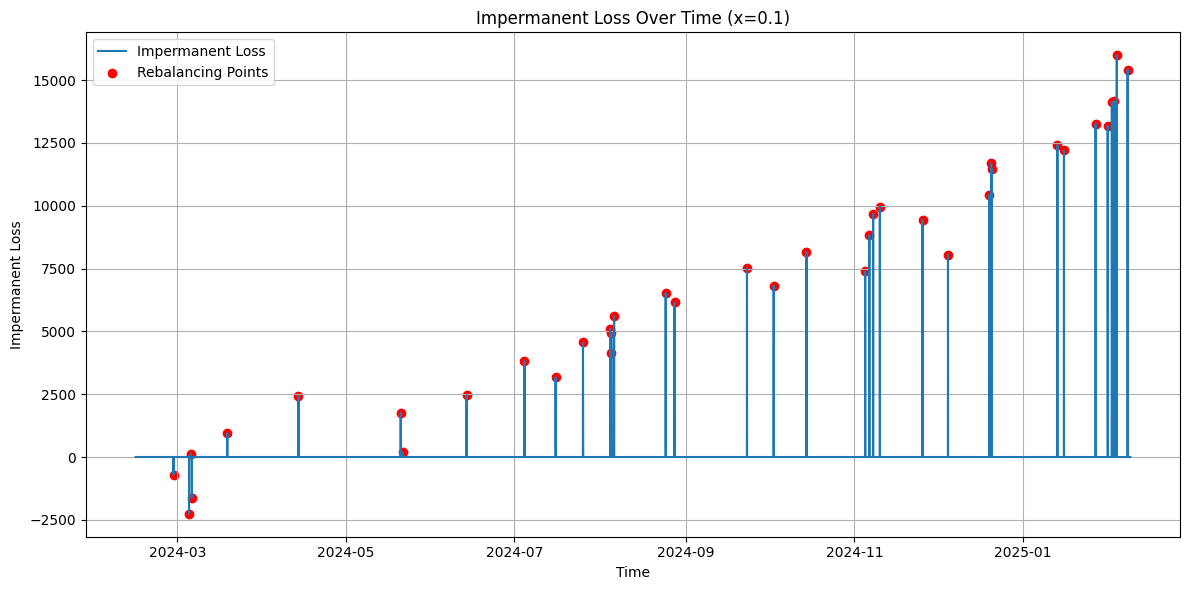

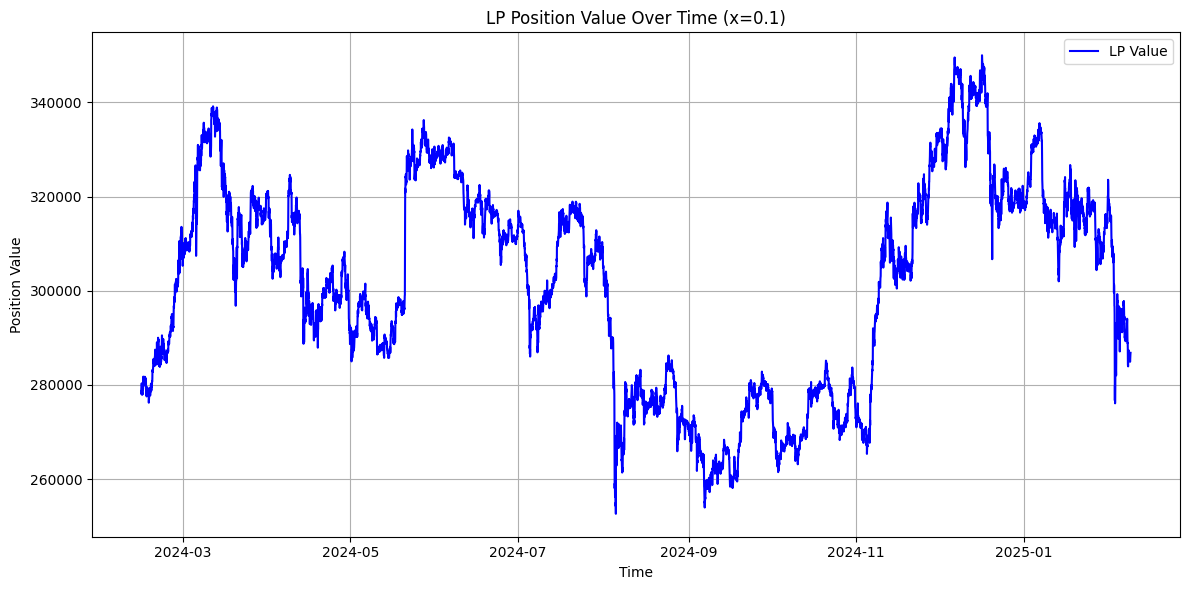

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_impermanent_loss(results_df, x_value):
    """
    Plots impermanent loss over time, highlighting rebalancing points.

    Args:
        results_df (pd.DataFrame): DataFrame with simulation results (including 'impermanent_loss').
        x_value (float): The x value used for the strategy.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['impermanent_loss'], label='Impermanent Loss')
    rebalancing_points = results_df[results_df['impermanent_loss'] != 0].index
    plt.scatter(rebalancing_points, results_df.loc[rebalancing_points, 'impermanent_loss'], color='red', marker='o', label='Rebalancing Points')
    plt.title(f'Impermanent Loss Over Time (x={x_value})')
    plt.xlabel('Time')
    plt.ylabel('Impermanent Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_position_value(results_df, x_value):
    """
    Plots the position value over time.

    Args:
        results_df (pd.DataFrame): DataFrame with simulation results (including 'lp_value').
        x_value (float): The x value used for the strategy.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['lp_value'], label='LP Value', color='blue')
    plt.title(f'LP Position Value Over Time (x={x_value})')
    plt.xlabel('Time')
    plt.ylabel('Position Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Optimal x_value
optimal_x_value = 0.10
# Backtest the LP strategy to get results_df
results_df, impermanent_losses = backtest_lp_strategy(eth_data.copy(), initial_eth=100, x=optimal_x_value)
# Plotting
plot_impermanent_loss(results_df, optimal_x_value)
plot_position_value(results_df, optimal_x_value)


In [ ]:
len(results_df['impermanent_loss'])

8634

In [ ]:
len(eth_data)

8635

In [ ]:
len(results_df[results_df['impermanent_loss'] == 0])

8596

In [ ]:
len(results_df[results_df['impermanent_loss'] != 0])

38

In [ ]:
results_df[results_df['impermanent_loss'] != 0].head()

,price,lp_value,hodl_value,impermanent_loss,daily_returns
timestamp,,,,,
2024-02-28 15:01:14,3373.853243,307266.128096,307970.119707,-703.991612,NaN
2024-03-05 06:01:53,3722.507551,323142.583225,325402.835104,-2260.251879,NaN
2024-03-05 20:03:40,3360.083612,307411.976085,307281.638178,130.337906,NaN
2024-03-06 06:03:24,3773.206014,326310.132859,327937.758245,-1627.625386,NaN
2024-03-19 02:04:53,3392.564842,309851.043305,308905.699651,945.343654,NaN


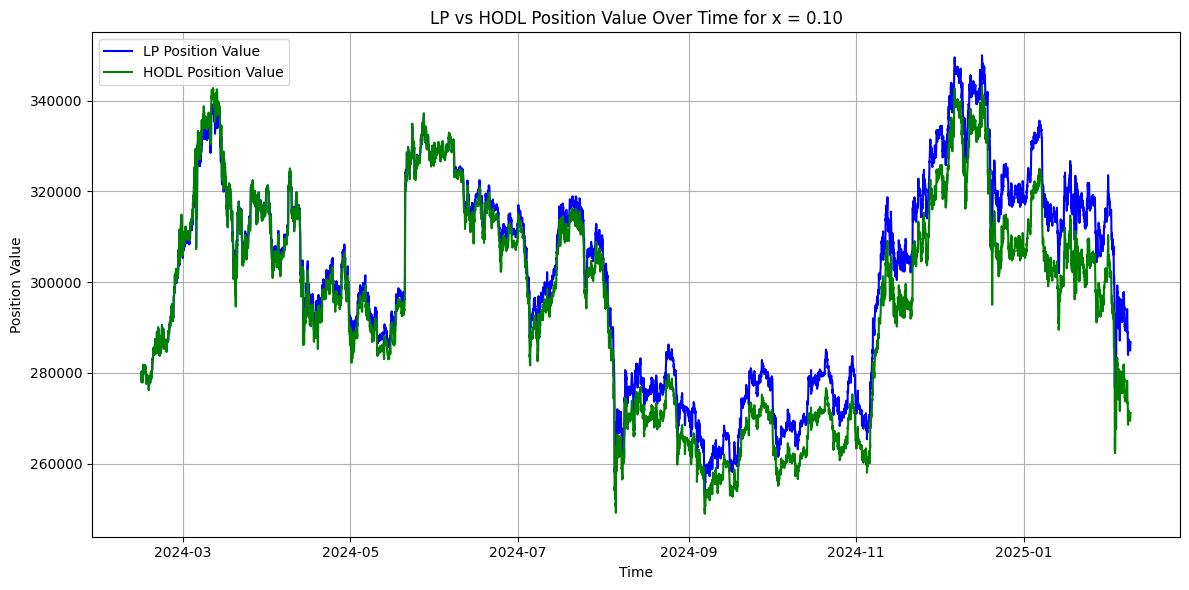

In [ ]:
import matplotlib.pyplot as plt

def plot_lp_and_hodl_values(results_df):
    """
    Plots the LP position value and HODL position value over time.

    Args:
        results_df (pd.DataFrame): DataFrame with 'lp_value' and 'hodl_value' columns.
    """
    plt.figure(figsize=(12, 6))

    # Plot LP position value
    plt.plot(results_df.index, results_df['lp_value'], label='LP Position Value', color='blue')

    # Plot HODL position value
    plt.plot(results_df.index, results_df['hodl_value'], label='HODL Position Value', color='green')

    # Adding titles and labels
    plt.title('LP vs HODL Position Value Over Time for x = 0.10')
    plt.xlabel('Time')
    plt.ylabel('Position Value')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming results_df is obtained from your backtesting function
results_df, _ = backtest_lp_strategy(eth_data.copy(), initial_eth=100, x=optimal_x_value)

# Call the plotting function
plot_lp_and_hodl_values(results_df)


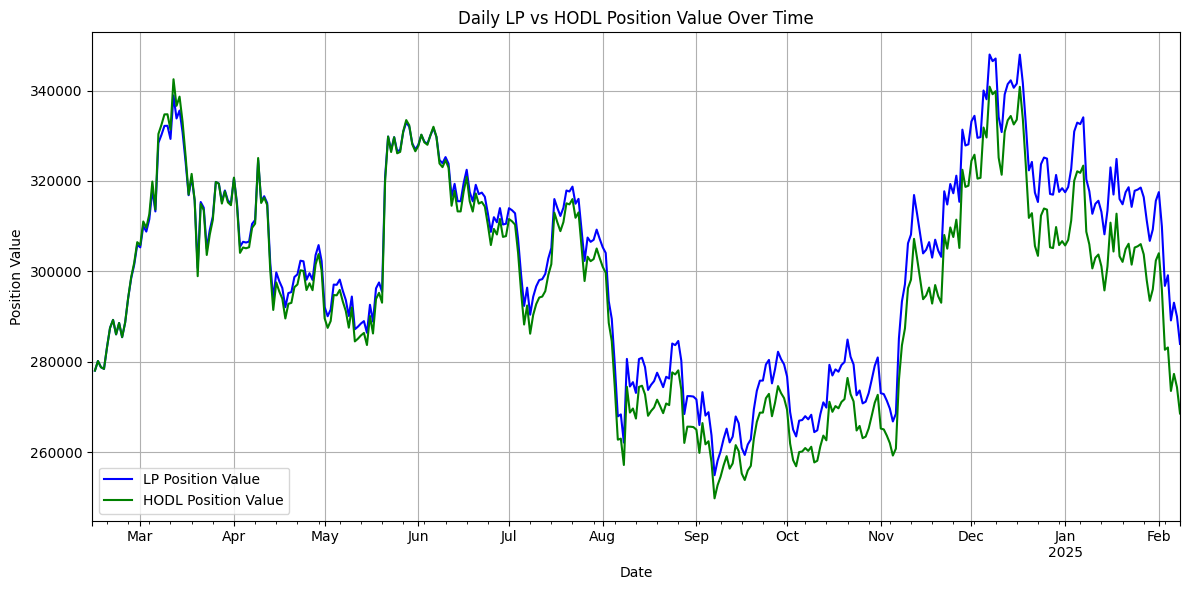

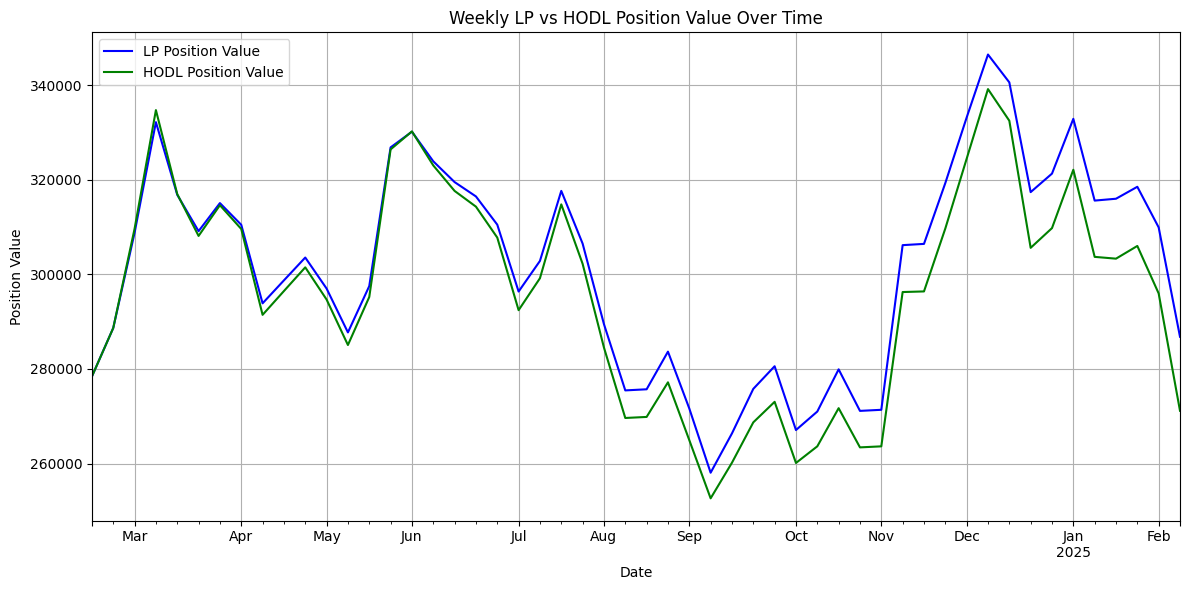

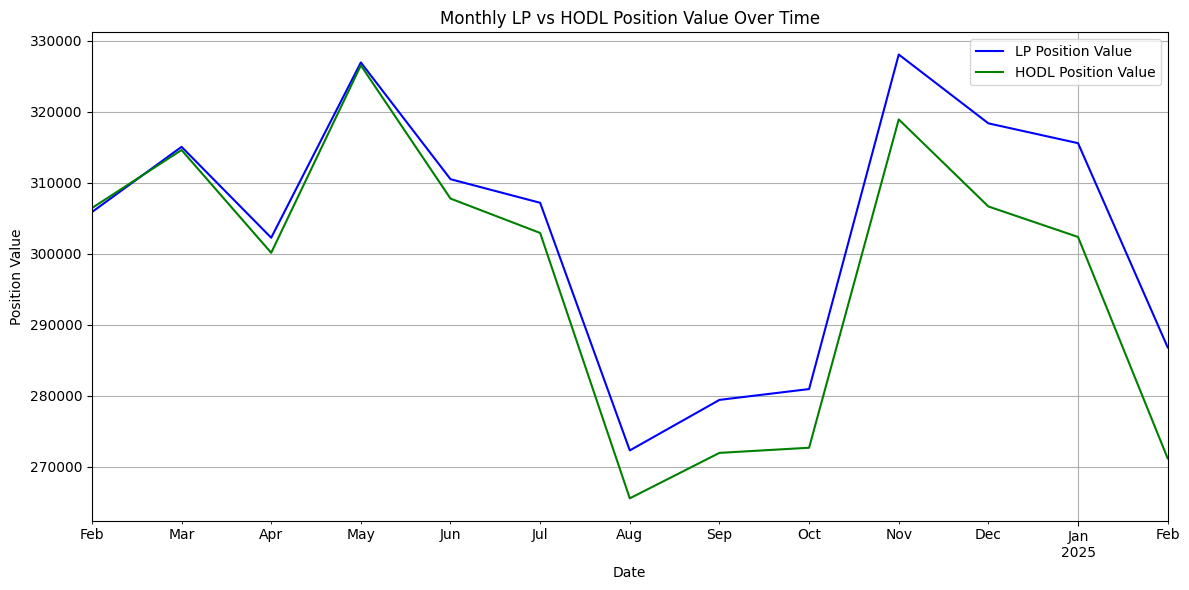

In [ ]:
import matplotlib.pyplot as plt

def plot_position_values_over_time(results_df):
    """
    Plots LP and HODL position values over time for daily, weekly, and monthly intervals.

    Args:
        results_df (pd.DataFrame): DataFrame with 'lp_value' and 'hodl_value' columns.
    """
    # Daily Plot
    plt.figure(figsize=(12, 6))
    results_df['lp_value'].resample('D').ffill().plot(label='LP Position Value', color='blue')
    results_df['hodl_value'].resample('D').ffill().plot(label='HODL Position Value', color='green')
    plt.title('Daily LP vs HODL Position Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Position Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Weekly Plot
    plt.figure(figsize=(12, 6))
    results_df['lp_value'].resample('W').ffill().plot(label='LP Position Value', color='blue')
    results_df['hodl_value'].resample('W').ffill().plot(label='HODL Position Value', color='green')
    plt.title('Weekly LP vs HODL Position Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Position Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Monthly Plot
    plt.figure(figsize=(12, 6))
    results_df['lp_value'].resample('M').ffill().plot(label='LP Position Value', color='blue')
    results_df['hodl_value'].resample('M').ffill().plot(label='HODL Position Value', color='green')
    plt.title('Monthly LP vs HODL Position Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Position Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Assuming results_df is obtained from your backtesting function
results_df, _ = backtest_lp_strategy(eth_data.copy(), initial_eth=100, x=optimal_x_value)

# Call the plotting function
plot_position_values_over_time(results_df)


In [113]:
eth_data

,timestamp,price
0,2024-02-14 21:00:56,2763.901342
1,2024-02-14 22:00:34,2785.549151
2,2024-02-14 23:01:37,2774.891328
3,2024-02-15 00:01:56,2780.175964
4,2024-02-15 01:00:38,2821.103770
...,...,...
8630,2025-02-08 16:03:51,2603.036732
8631,2025-02-08 17:03:49,2611.309897
8632,2025-02-08 18:03:57,2629.507374
8633,2025-02-08 19:04:23,2632.167718


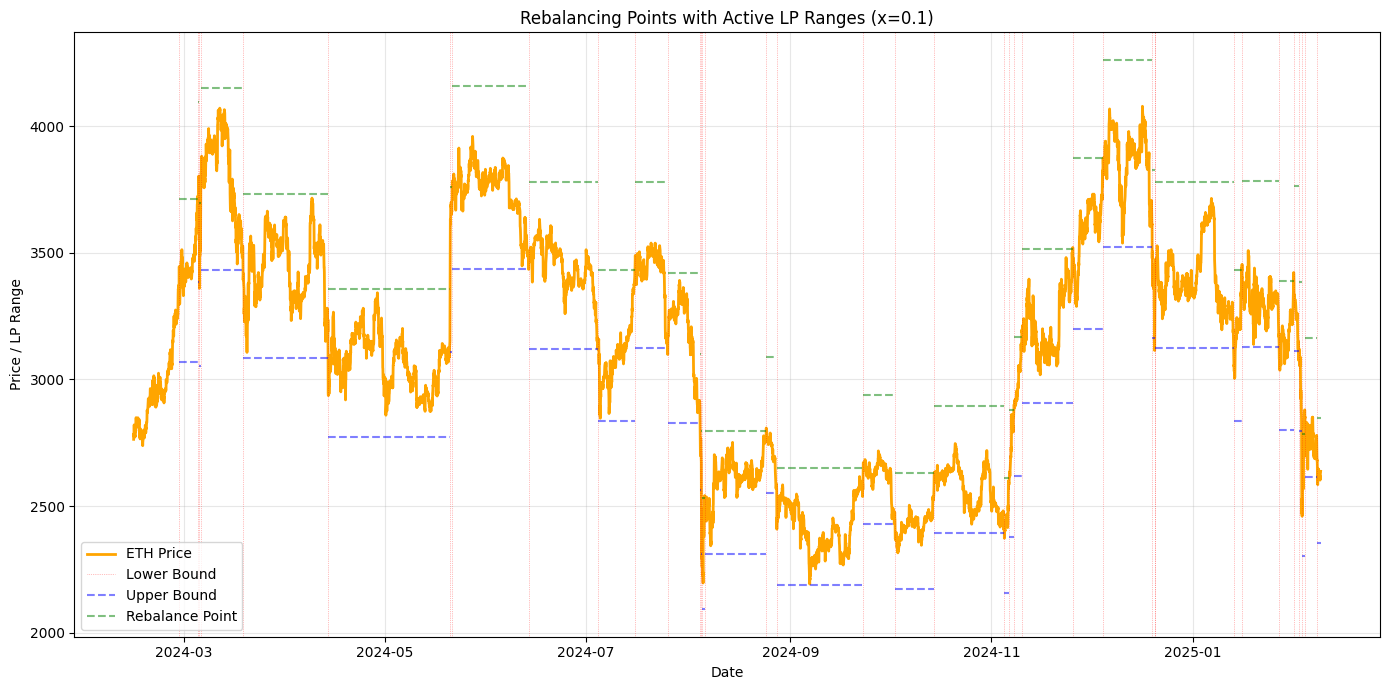

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_rebalancing_ranges(eth_data, results_df, x_value):
    """
    Plots rebalancing points with active LP ranges.
    """
    eth_data['timestamp'] = pd.to_datetime(eth_data['timestamp'])
    eth_data.set_index('timestamp', inplace=True)

    plt.figure(figsize=(14, 7))

    # Plot historical prices
    plt.plot(eth_data.index, eth_data['price'], label='ETH Price', color='orange', linewidth=2)

    # Extract rebalancing points
    rebalance_points = results_df[results_df['impermanent_loss'] != 0].index.tolist()

    # Plot LP ranges at rebalance points
    current_lower = None
    current_upper = None
    for point in rebalance_points:
        if point in eth_data.index:
            price = eth_data.loc[point, 'price']
            lower_bound = price / (1 + x_value)
            upper_bound = price * (1 + x_value)

            # Update current bounds
            if current_lower is not None:
                plt.plot([prev_point, point], [current_lower, current_lower], color='blue', linestyle='--', alpha=0.5)
                plt.plot([prev_point, point], [current_upper, current_upper], color='green', linestyle='--', alpha=0.5)

            current_lower = lower_bound
            current_upper = upper_bound
            prev_point = point

            # Mark rebalancing point
            plt.axvline(x=point, color='red', linestyle=':', linewidth=0.5, alpha=0.5)

    # Plot final segment of bounds
    if current_lower is not None:
        plt.plot([prev_point, eth_data.index[-1]], [current_lower, current_lower], color='blue', linestyle='--', alpha=0.5)
        plt.plot([prev_point, eth_data.index[-1]], [current_upper, current_upper], color='green', linestyle='--', alpha=0.5)

    plt.title(f'Rebalancing Points with Active LP Ranges (x={x_value})')
    plt.xlabel('Date')
    plt.ylabel('Price / LP Range')
    plt.legend(['ETH Price', 'Lower Bound', 'Upper Bound', 'Rebalance Point'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Assuming you have your eth_data and results_df from your backtest
optimal_x_value = 0.10
plot_rebalancing_ranges(eth_data, results_df, optimal_x_value)
